In [1]:
# -*- coding: utf8

from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Para evitar a confusão da aula passada, colocando alguns defaults!
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 10 - Mais ICs, Bootstraps e ABs

## Introdução

Neste notebook vamos continuar nossa exploração de intervalos de confiança e o significado dos mesmos. Em particular, vamos continuar também usando o **bootstrap** para entender o conceito. Lembre-se que a ideia de um intervalo de confiança é entender _a média da população com base em uma amostra_. Por isso o teorema central do limite é tão importante. Na aula anterior iniciamos assumindo que conhecíamos a população. Quando isto ocorre tudo é muito mais simples, quase nunca é verdade. Então como falar algo da população usando apenas uma amostra?

Perguntas como esta acima são a base da __estatística frequentista__. Assumimos que uma verdade existe, na população, e queremos saber como entender essa população só com uma amostra.

Para este notebook, preparei algumas funções abaixo que computa.
1. IC da média usando o TCL
1. IC da média usando bootstrap
1. IC da diferença entre duas médias usando bootstrap

## Funções abaixo com documentação

In [4]:
def bootstrap_mean(df, column, n=5000, size=None):
    '''
    Faz um boostrap da média. Gera amostras.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df[column].sample(size, replace=True)
        values[i] = sample.mean()
    return values

In [5]:
def ic_bootstrap(df, column, n=5000, size=None):
    '''
    Faz um IC boostrap da média. Gera um Intervalo.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
        
    values = bootstrap_mean(df, column, n, size)
    return (np.percentile(values, 2.5), np.percentile(values, 97.5))

In [6]:
def ic_classic(df, column):
    '''
    Faz um IC clássico usando o teorema central do limite.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    data = df[column]
    mean = data.mean()
    std = data.std(ddof=1)
    se = std / np.sqrt(len(data))
    
    return (mean - 1.96 * se, mean + 1.96 * se)

## Dados Sintéticos

Vamos, mais uma vez entender um IC usando o bootstrap. Inicialmente, vamos assumir uma população $Normal(0, 1)$. Obviamente, teremos média perto de = 0 e std = 1. 

Caso queira, brinque com o size acima e observe como a média fica mais correta. Além do mais, códigos scipy usam dois parâmetros: __loc__ e __scale__. LEIA ATENTAMENTE A DOCUMENTAÇÃO ANTES DE USAR AS DISTRIBUIÇÕES. ÀS VEZES, LOC e SCALE MAPEAM DIRETAMENTE PARA O UM LIVRO/WIKIPEDIA. NO CASO DA NORMAL BATE.

__Sobre Scipy__. Leia o link abaixo para entender a API um pouco mais.
https://www.johndcook.com/blog/distributions_scipy/

In [7]:
pop = ss.distributions.norm.rvs(size=10000, loc=0, scale=1)

In [8]:
pop.mean()

0.022500660966507539

In [9]:
pop.std(ddof=1)

0.99378207099647542

Como meu código foi feito com DataFrames, vou converter os dados para um DataFrame. Além do mais, vou comparar o IC do bootstrap com o IC real ao variar o número de amostras no meu Bootstrap.

In [10]:
pop = ss.distributions.norm.rvs(size=100, loc=0, scale=1)
data = pd.DataFrame()
data['values'] = pop

serie_1 = []
serie_2 = []
ns = np.arange(1, 1001)
for n in ns:
    ic_bs = ic_bootstrap(data, 'values', n=n)
    ic_c = ic_classic(data, 'values')
    tamanho_bs = ic_bs[1] - ic_bs[0]
    tamanho_c = ic_c[1] - ic_c[0]
    
    serie_1.append(tamanho_bs)
    serie_2.append(tamanho_c)

Text(0, 0.5, 'Tamanho do IC')

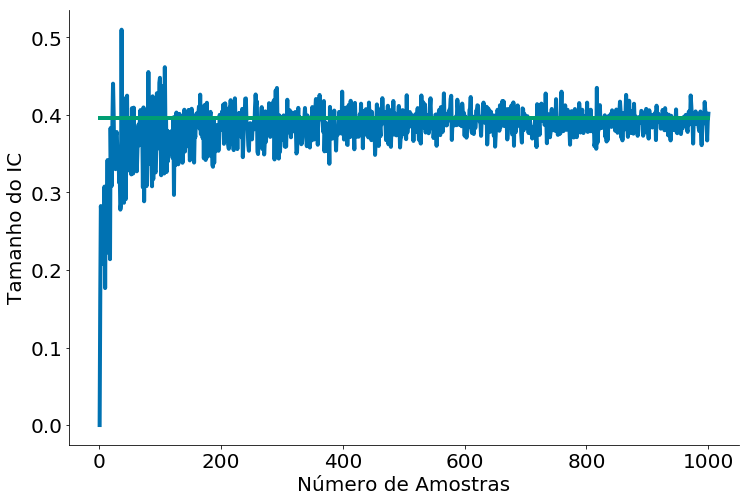

In [11]:
plt.plot(ns, serie_1, label='Bootstrap')
plt.plot(ns, serie_2, label='Real')
despine()
plt.xlabel('Número de Amostras')
plt.ylabel('Tamanho do IC')

## Dados Reais, comparando dois grupos (A/B)

Agora vamos explorar dados reais para entender se existe algum efeito entre fumar o peso.

### Algumas hipóteses

Tente brincar com os dados para entender um pouco mais cada caso.

1. __Mães que fumam tendem a ter bebês com pesos menores.__
1. Mães que têm idade menor tendem a ter bebês com pesos menores.
1. Mães que têm peso menor tendem a ter bebês com pesos menores.

Vamos explorar a primeira.

Primeiro, vamos dar uma olhada na base como um todo.

In [24]:
df = pd.read_csv('baby.csv')

# Convertendo para unidades não EUA
df['Birth Weight'] = 0.0283495 * df['Birth Weight']
df['Maternal Pregnancy Weight'] = 0.0283495 * df['Maternal Pregnancy Weight']
df['Maternal Height'] = 0.0254 * df['Maternal Height']

df.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,3.401940,284,27,1.5748,2.834950,False
1,3.203493,282,33,1.6256,3.827183,False
2,3.628736,279,28,1.6256,3.260193,True
3,3.061746,282,23,1.7018,3.543687,True
4,3.855532,286,25,1.5748,2.636503,False


In [25]:
df.describe()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,3.386703,279.101363,27.228279,1.626855,3.642307
std,0.519609,16.010305,5.817839,0.064163,0.587807
min,1.559222,148.000000,15.000000,1.346200,2.466407
25%,3.061746,272.000000,23.000000,1.574800,3.238930
50%,3.401940,280.000000,26.000000,1.625600,3.543687
75%,3.713785,288.000000,31.000000,1.676400,3.940580
max,4.989512,353.000000,45.000000,1.828800,7.087375


Agora vamos ver os dados de quem fuma.

In [13]:
smokers = df[df['Maternal Smoker'] == True]
smokers.describe()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight
count,459.000000,459.000000,459.000000,459.000000,459.000000
mean,3.226717,277.897603,26.736383,1.628256,3.598101
std,0.518654,15.201427,5.713139,0.066135,0.566761
min,1.644271,223.000000,15.000000,1.346200,2.466407
25%,2.863300,271.000000,22.000000,1.587500,3.175144
50%,3.260193,278.000000,26.000000,1.625600,3.543687
75%,3.572037,286.000000,30.000000,1.676400,3.869707
max,4.620969,330.000000,43.000000,1.828800,6.095142


Contra os dados de quem não fuma.

In [14]:
no_smokers = df[df['Maternal Smoker'] == False]
no_smokers.describe()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight
count,715.000000,715.000000,715.000000,715.000000,715.000000
mean,3.489407,279.874126,27.544056,1.625955,3.670685
std,0.493953,16.472823,5.866317,0.062895,0.599603
min,1.559222,148.000000,17.000000,1.422400,2.523105
25%,3.203493,273.000000,23.000000,1.574800,3.260193
50%,3.486988,281.000000,27.000000,1.625600,3.572037
75%,3.798833,289.000000,31.000000,1.676400,3.968930
max,4.989512,353.000000,45.000000,1.803400,7.087375


Oberserve que sim, existem diferenças nos valores. Porém precisamos de um __arcabouço__ para entender exatamente como comparar os grupos. Não é impossível que tais erros sejam factíveis em uma base. Até na distribuição temos diferença, mas podemos fazer alguma coisa com uma amostra?!

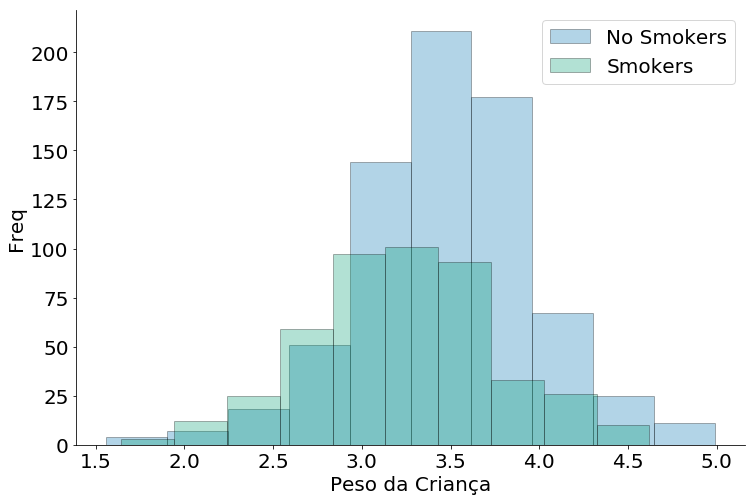

In [15]:
plt.hist(no_smokers['Birth Weight'], alpha=0.3, edgecolor='k', label='No Smokers')
plt.hist(smokers['Birth Weight'], alpha=0.3, edgecolor='k', label='Smokers')
despine()
plt.xlabel('Peso da Criança')
plt.ylabel('Freq')
plt.legend()

Por isso que ICs são bem interessante. Vemos qual a chance do parâmetro na população, depois comparamos os ICs.

Abaixo temos o IC de cada caso com bootstrap. Podemos falar alguma coisa?!

In [16]:
ic_bootstrap(smokers, 'Birth Weight')

(3.1807644891067537, 3.2747069498910677)

In [17]:
ic_bootstrap(no_smokers, 'Birth Weight')

(3.4529661262762232, 3.5257698230069932)

In [18]:
samples_smokers = bootstrap_mean(smokers, 'Birth Weight')
samples_no_smokers = bootstrap_mean(no_smokers, 'Birth Weight')
to_plot = pd.DataFrame()
to_plot['smoker_boot'] = samples_smokers
to_plot['no_smoker_boot'] = samples_no_smokers

Text(0, 0.5, 'Media')

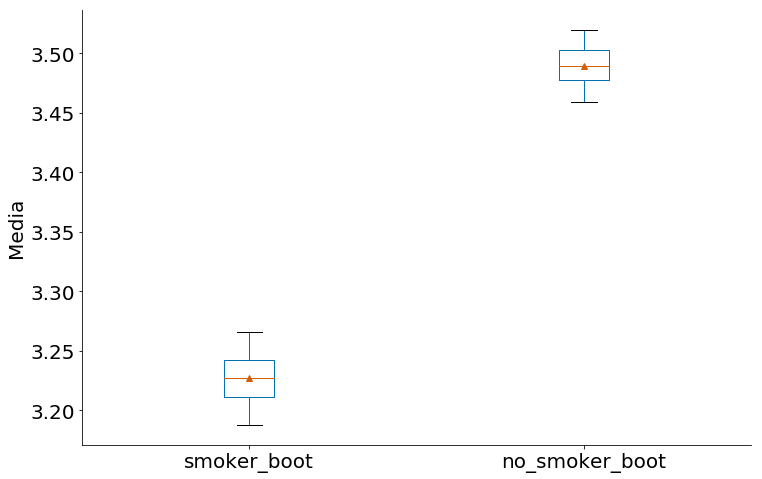

In [19]:
to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)
despine()
plt.ylabel('Media')

Uma forma mais simples de entender é comparar a diferença entre os dois grupos. Note que o bootstrap também pode ser utilizado, agora vamos comparar a média de cada amostra. É o mesmo arcabouço.

In [20]:
def bootstrap_diff(df1, df2, column, n=5000, size=None):
    '''
    Faz um boostrap da diferença das média. Gera amostras.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size, replace=True)
        sample2 = df2[column].sample(size, replace=True)
        values[i] = sample1.mean() - sample2.mean()
    return values

In [21]:
caso2 = pd.DataFrame()
diff = bootstrap_diff(smokers, no_smokers, 'Birth Weight')

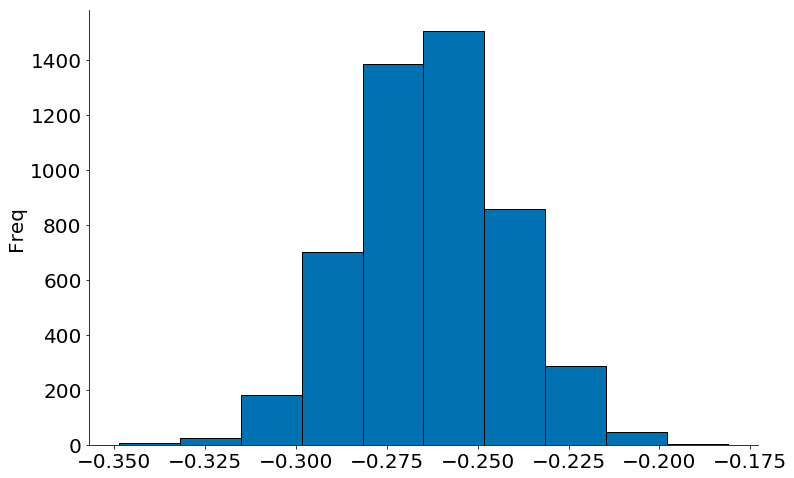

In [22]:
plt.hist(diff, edgecolor='k')
plt.ylabel('Média Fumantes - Não Fumantes')
plt.ylabel('Freq')
despine()

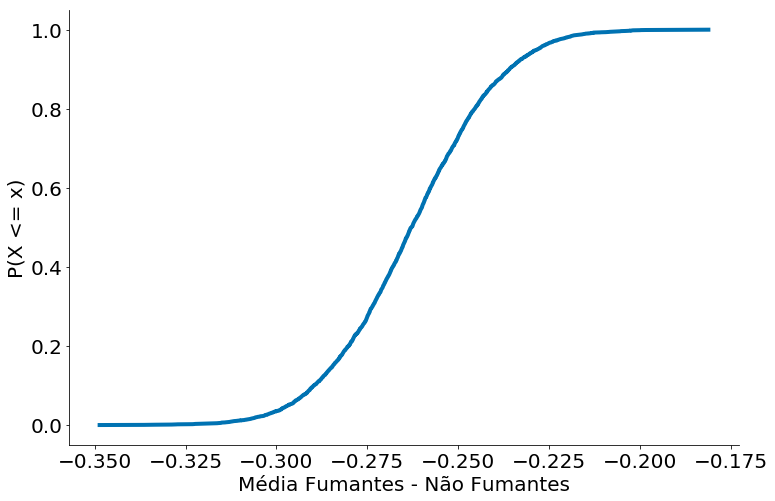

In [23]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(diff)
plt.plot(ecdf.x, ecdf.y)
plt.xlabel('Média Fumantes - Não Fumantes')
plt.ylabel('P(X <= x)')
despine()

## Para Leituras Futuras

1. Recomendo o Capítulo de Bootstrap do "All of Statistic". Tem na Biblioteca. Outro post bom é o link abaixo.
1. Lembre-se que este exemplo no inferentialthinking usa testes hipóteses com pvalues, chega no mesmo resultado.
1. https://stats.stackexchange.com/questions/26088/explaining-to-laypeople-why-bootstrapping-works